In [5]:
import pandas as pd
import numpy as np

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import librosa
import librosa.display

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D,Flatten,Dropout,BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category = DeprecationWarning)

#Data Path
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

2024-05-22 03:35:06.883991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 03:35:06.884089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 03:35:07.017585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Ravdess Dataframe

Filename identifiers as per the official RAVDESS website:

+ Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
+ Vocal channel (01 = speech, 02 = song).
+ Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
+ Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
+ Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
+ Repetition (01 = 1st repetition, 02 = 2nd repetition).
+ Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
An example of an audio filename. 02-01-06-01-02-01-12.mp4 . The meta data for the audio file is:

+ Video-only (02)
+ Speech (01)
+ Fearful (06)
+ Normal intensity (01)
+ Statement "dogs" (02)
+ 1st Repetition (01)
+ 12th Actor (12) - Female (as the actor ID number is even)

In [6]:
# Creating Ravdess Dataframe
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # Extract files for each coresponding actors
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # Third part in each file presents the emotion
        
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# Dataframe for emotions
emotion_df = pd.DataFrame(file_emotion , columns = ['Emotions'])
# Dataframe for file paths
path_df = pd.DataFrame(file_path , columns = ['Paths'])

Ravdess_df = pd.concat([emotion_df , path_df],axis = 1)

# Mapping
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad',
                             5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'}, inplace=True)


Ravdess_df.head()

,Emotions,Paths
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [7]:
import os
# Crema DataFrame
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Storing file paths
    file_path.append(Crema + file)
    
    # Storing file emotions
    part = file.split('_')
    
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# Dataframe for emotions
emotion_df = pd.DataFrame(file_emotion , columns = ['Emotions'])

# DataFrame for file paths
path_df = pd.DataFrame(file_path , columns = ['Paths'])

Crema_df = pd.concat([emotion_df , path_df],axis = 1)
Crema_df.head()

,Emotions,Paths
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [8]:
# TESS dataset
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess+dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess+dir+'/'+file)

# Dataframe for emotions
emotion_df = pd.DataFrame(file_emotion , columns = ['Emotions'])

# Dataframe for file paths
path_df = pd.DataFrame(file_path , columns = ['Paths'])

Tess_df = pd.concat([emotion_df , path_df] , axis = 1)
Tess_df.head()

,Emotions,Paths
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


## Crema-D Dataframe

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

+ 'a' = 'anger'
+ 'd' = 'disgust'
+ 'f' = 'fear'
+ 'h' = 'happiness'
+ 'n' = 'neutral'
+ 'sa' = 'sadness'
+ 'su' = 'surprise'

In [9]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee+file)
    part = file.split('_')[1]
    ele = part[:-6]
    
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# Dataframe for emotions
emotion_df = pd.DataFrame(file_emotion , columns = ['Emotions'])

# Dataframe for file paths
path_df = pd.DataFrame(file_path , columns = ['Paths'])
Savee_df = pd.concat([emotion_df , path_df],axis = 1)
Savee_df.head()

,Emotions,Paths
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [10]:
# Create Dataframe for 4 datasets
data_path = pd.concat([Ravdess_df , Crema_df , Tess_df , Savee_df],axis = 0)
data_path.to_csv('data_path.csv',index = False)
data_path.head()

,Emotions,Paths
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


## Plot waveplots and spectograms

+ Waveplots - Waveplots let us know the loudness of the audio at a given time.
+ Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [11]:
def create_waveplot(data , sr , e):
    plt.figure(figsize=(10,3))
    plt.title('Waveplot for audio with {} emotion'.format(e),size = 15)
    librosa.display.waveshow(data , sr = sr)
    plt.show()

def create_spectrogram(data ,sr , e):
    # STFT converts the data into short time fourer transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12,3))
    plt.title('Spectrogram for audio with {} emotion'.format(e),size = 15)
    librosa.display.specshow(Xdb , sr = sr , x_axis = 'time' , y_axis = 'hz')
    plt.colorbar()

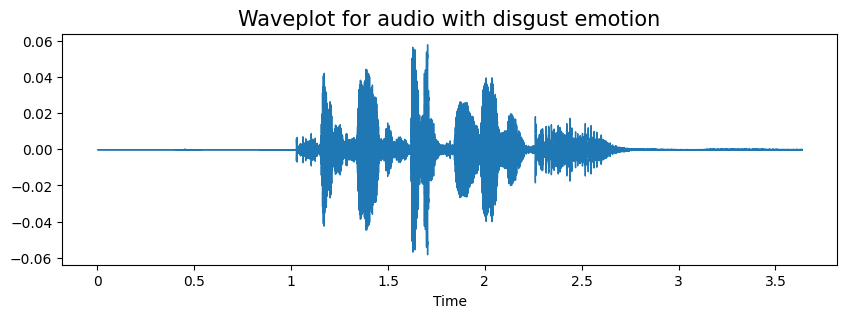

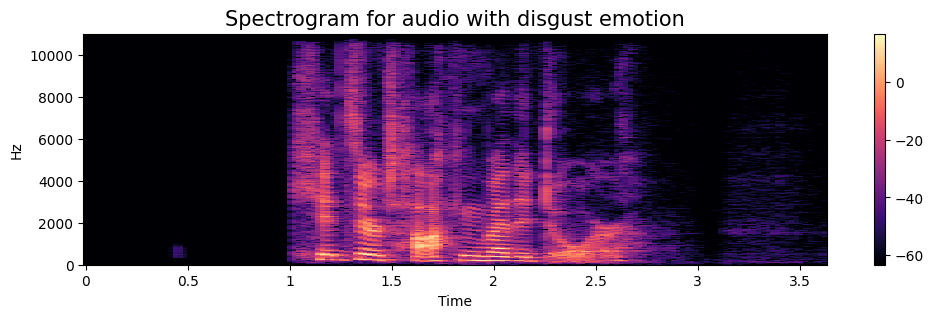

In [12]:
emotion = 'disgust'
path = np.array(data_path.Paths[data_path.Emotions == emotion])[1]

data, sampling_rate = librosa.load(path)
create_waveplot(data,sampling_rate,emotion)
create_spectrogram(data,sampling_rate , emotion)
Audio(path)

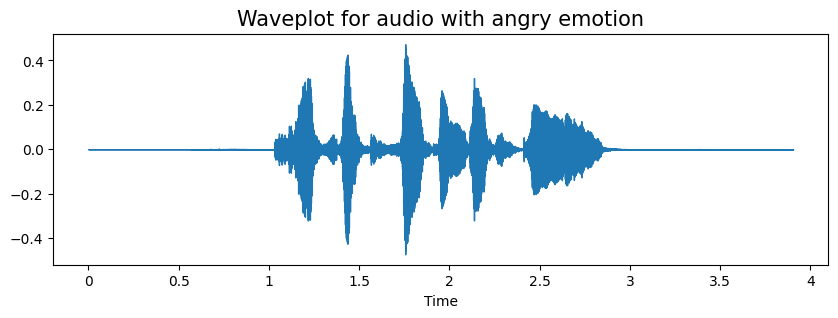

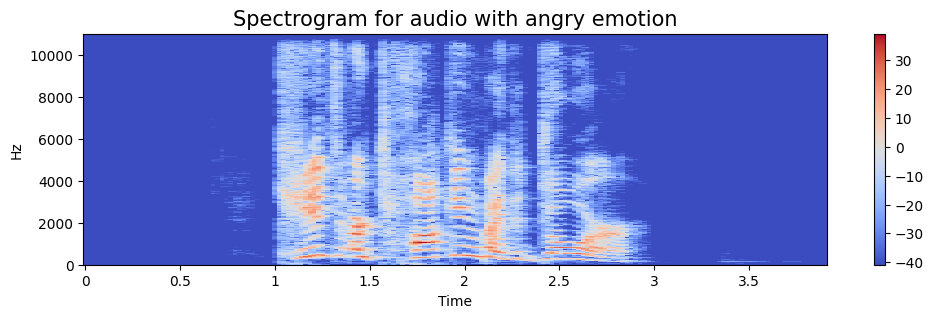

In [13]:
emotion = 'angry'
path = np.array(data_path.Paths[data_path.Emotions==emotion])[1]
data , sampling_rate = librosa.load(path)
create_waveplot(data , sampling_rate , emotion)
create_spectrogram(data , sampling_rate , emotion)
Audio(path)

## Data Augmentation

+ Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
+ To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
+ The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
+ In order to this to work adding the perturbations must conserve the same label as the original training sample.
+ In images data augmention can be performed by shifting the image, zooming, rotating ...

In [20]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size = data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data , rate = .8)

def shift(data):
    shift_range = int(np.random.uniform(low =- 5 , high = 5)*1000)
    return np.roll(data,shift_range)

def pitch(data):
    return librosa.effects.pitch_shift(data , sr = sample_rate ,
                                      n_steps = .7)

#### 1.Original Audio

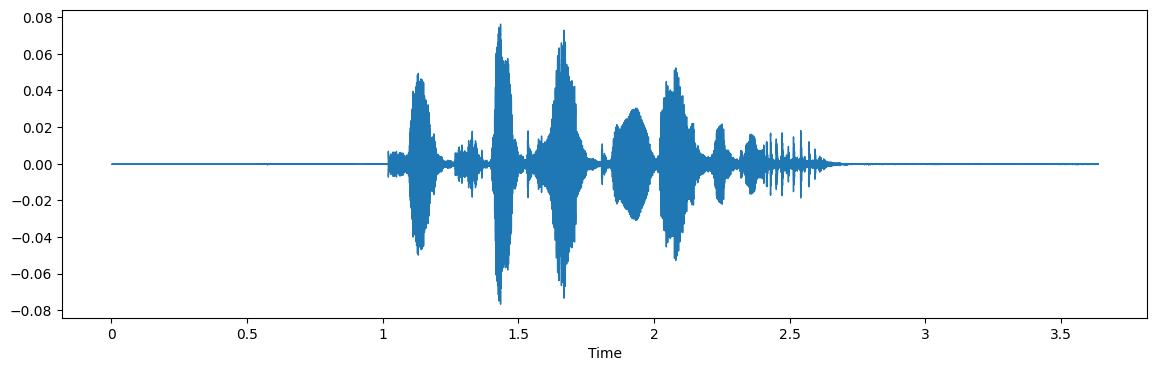

In [15]:
# Taking examples and test the techniques
path = np.array(data_path.Paths)[1]
data , sample_rate = librosa.load(path)

plt.figure(figsize = (14,4))
librosa.display.waveshow(y = data , sr = sample_rate)
Audio(path)

#### 2.Noise Injection

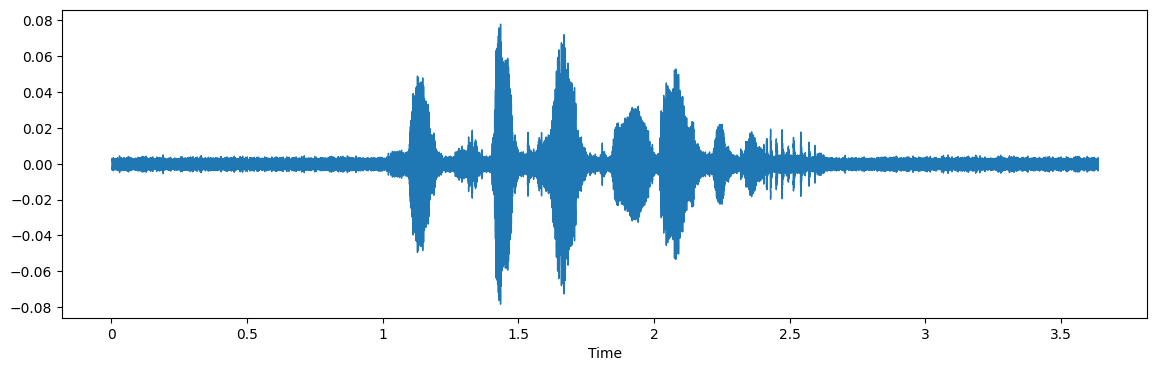

In [16]:
x = noise(data)
plt.figure(figsize = (14,4))
librosa.display.waveshow(y=x , sr = sample_rate)
Audio(x , rate = sample_rate)

#### 3.Stretching

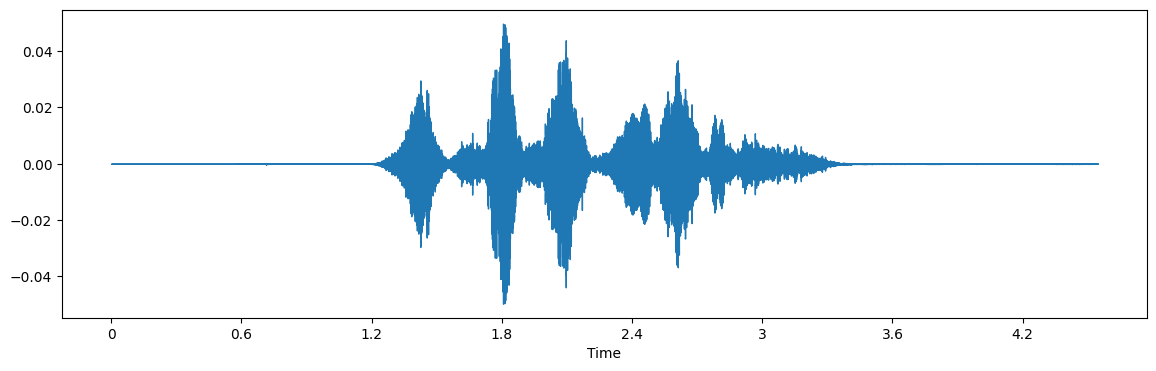

In [21]:
x = stretch(data)
plt.figure(figsize = (14,4))
librosa.display.waveshow(y = x , sr = sample_rate)
Audio(x,rate = sample_rate)

#### 4.Shifting

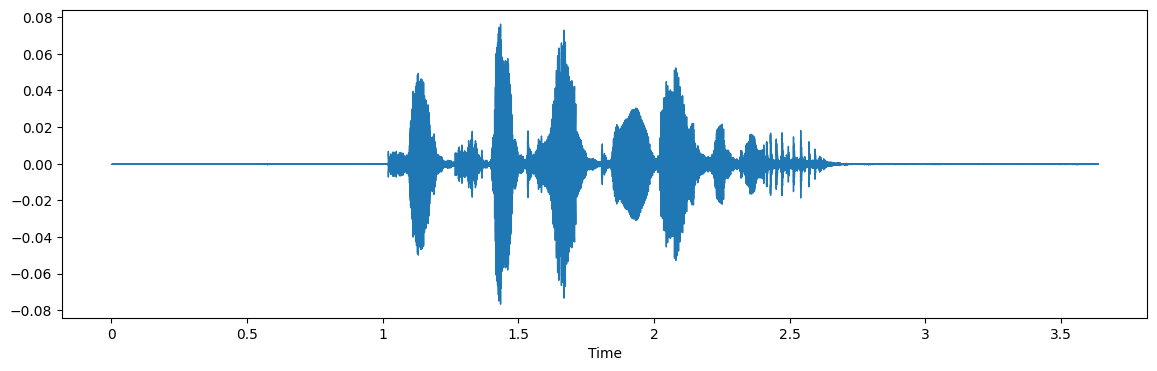

In [22]:
x = shift(data)
plt.figure(figsize = (14,4))
librosa.display.waveshow(y = x , sr = sample_rate)
Audio(x, rate = sample_rate)

#### 5.Pitch

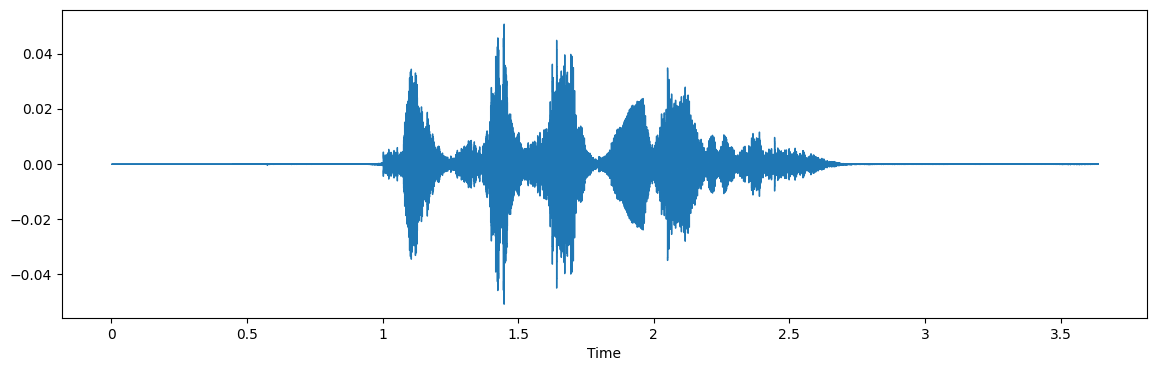

In [23]:
x = pitch(data)
plt.figure(figsize = (14,4))
librosa.display.waveshow(y = x , sr = sample_rate)
Audio(x , rate = sample_rate)

## Feature Extraction

+ Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.
One can perform several transformations on it to extract valuable features out of it.

1.Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.

2.Energy : The sum of squares of the signal values, normalized by the respective frame length.

3.Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.

4.Spectral Centroid : The center of gravity of the spectrum.

5.Spectral Spread : The second central moment of the spectrum.

6.Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.

7.Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.

8.Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.

9.MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

10.Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).

11.Chroma Deviation : The standard deviation of the 12 chroma coefficients.

In [33]:
def extract_features(data):
    #ZCR 
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis = 0)
    result = np.hstack((result , zcr)) # Stacking horizontally
    
    #Chroma stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft,sr=sample_rate).T,
                         axis = 0)
    result = np.hstack((result , chroma_stft))
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data , sr=sample_rate).T,
                  axis = 0)
    result = np.hstack((result , mfcc))
    
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T,axis = 0)
    result = np.hstack((result , rms))
    
    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,
                 axis = 0)
    result = np.hstack((result , mel))
    
    
    
    
    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data,
                                                                 sr=sample_rate).T,
                               axis = 0)
    result = np.hstack((result , spectral_centroid))
    
    # Spectral Spread
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data,
                                                          sr=sample_rate).T,
                                axis = 0)
    result = np.hstack((result , spectral_bandwidth))
    
    #Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data , 
                                                               sr=sample_rate).T,
                              axis = 0)
    result = np.hstack((result , spectral_rolloff))
    
    return result

In [36]:
def get_features(path):
    # Duration and Offset used for take care of no audio at the start
    # And ending of each audio files
    
    data , sample_rate = librosa.load(path , duration = 2.5 , offset = .6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result , res2)) # Stacking vertically
    
    # Data with scretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result , res3)) # Stacking vertically
    
    return result

In [38]:
X , Y = [] , []
for path , emotion in zip(data_path.Paths , data_path.Emotions):
    features = get_features(path)
    for ele in features:
        X.append(ele)
        Y.append(emotion)
        
len(X),len(Y),data_path.Paths.shape

(36486, 36486, (12162,))

In [39]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index = False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,2976.999948,2420.345218,5528.948975,surprise
1,0.327393,0.718477,0.739844,0.725385,0.706726,0.733985,0.709938,0.711908,0.686779,0.706122,...,0.000916,0.001154,0.001137,0.001015,0.000962,8.147081e-04,4438.638965,3108.567037,8257.484945,surprise
2,0.185699,0.701609,0.669991,0.646497,0.569470,0.522184,0.620172,0.694164,0.706134,0.679070,...,0.000048,0.000024,0.000053,0.000074,0.000031,2.444069e-06,3022.097390,2407.062338,5583.719076,surprise
3,0.256113,0.621621,0.580278,0.598515,0.628296,0.598014,0.597272,0.650352,0.698635,0.681863,...,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,2767.931056,2297.068163,5104.565430,neutral
4,0.326638,0.702651,0.712441,0.767901,0.768269,0.730799,0.673294,0.719425,0.748318,0.712750,...,0.000253,0.000257,0.000254,0.000256,0.000257,2.421562e-04,4433.899708,3176.566752,8359.169515,neutral


## Data Preparation
+ Normlizing and splitting data

In [40]:
X = Features.iloc[:,:-1].values
Y = Features['labels'].values

# Multiclass Classification hence the one hot encoding
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# Splitting data
x_train , x_test , y_train , y_test = train_test_split(X , Y ,
                                                      random_state = 0,
                                                      shuffle = True)


x_train.shape , y_train.shape , x_test.shape , y_test.shape

((27364, 165), (27364, 8), (9122, 165), (9122, 8))

In [42]:
# Scaling data with sklearn's Standard Scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


x_train.shape , y_train.shape , x_test.shape , y_train.shape

((27364, 165), (27364, 8), (9122, 165), (27364, 8))

In [45]:
# Making sure the data is compatible for the model
x_train = np.expand_dims(x_train , axis = 2)
x_test = np.expand_dims(x_test , axis = 2)


x_train.shape , y_train.shape , x_test.shape , y_test.shape

((27364, 165, 1), (27364, 8), (9122, 165, 1), (9122, 8))

## Model Building

In [46]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [47]:
rlrp = ReduceLROnPlateau(monitor = 'loss' ,
                        factor = .4,
                        verbose = 0 ,
                        patience = 2 , min_lr = 0.0000001)
history = model.fit(x_train , y_train , batch_size = 32 , epochs = 50 , 
                   validation_data = (x_test , y_test) , callbacks = [rlrp])

Epoch 1/50
 37/856 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1600 - loss: 2.0806

I0000 00:00:1716353491.060061      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


856/856 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.2189 - loss: 1.9199 - val_accuracy: 0.3584 - val_loss: 1.5599 - learning_rate: 0.0010
Epoch 2/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3317 - loss: 1.6260 - val_accuracy: 0.4235 - val_loss: 1.4601 - learning_rate: 0.0010
Epoch 3/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3801 - loss: 1.5195 - val_accuracy: 0.4456 - val_loss: 1.4545 - learning_rate: 0.0010
Epoch 4/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4020 - loss: 1.4641 - val_accuracy: 0.4650 - val_loss: 1.3284 - learning_rate: 0.0010
Epoch 5/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4299 - loss: 1.3994 - val_accuracy: 0.4808 - val_loss: 1.2865 - learning_rate: 0.0010
Epoch 6/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4514 - loss: 1.3376 - val_accuracy: 0.5032 - val_loss: 1.2217 - learning_rate: 0.0010
Epoch 7/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4727 - loss: 1.3047 - val_accur

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6219 - loss: 1.0798
Accuracy of our model on test data :  61.280423402786255 %


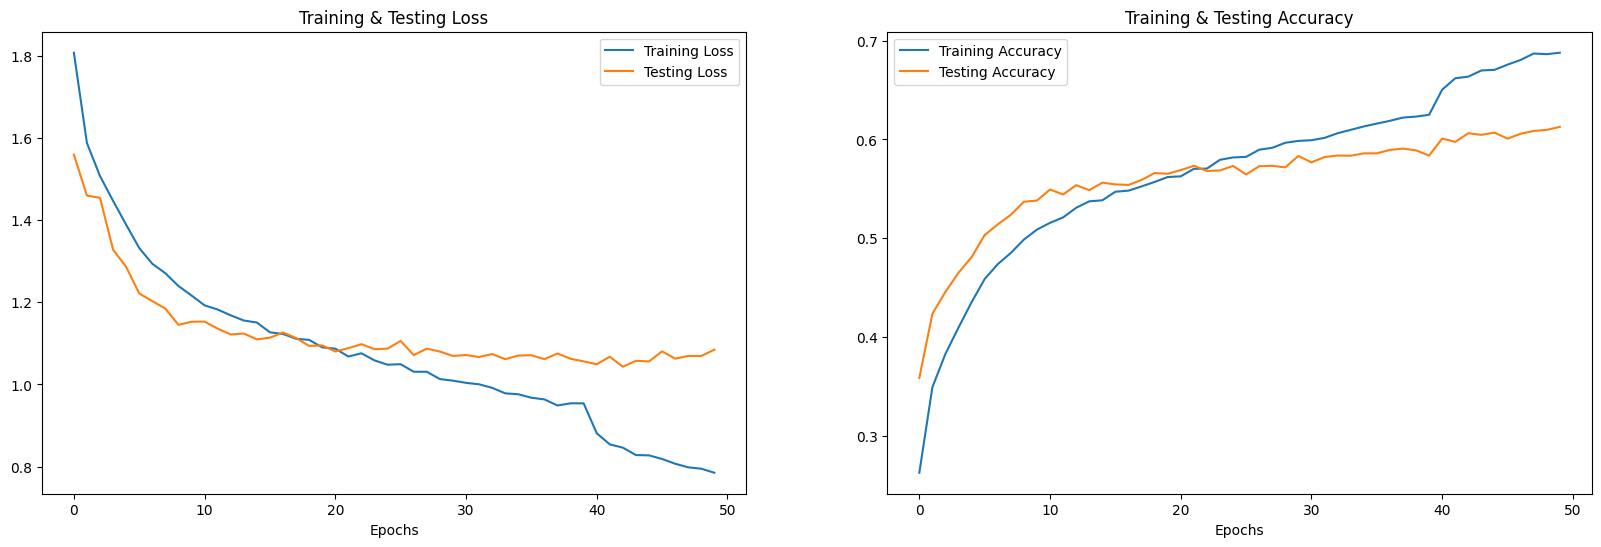

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [49]:
# Predicting on test data
pred_test = model.predict(x_test) # Output = logits
y_pred = encoder.inverse_transform(pred_test) # Output = prediction probability

y_test = encoder.inverse_transform(y_test)


df = pd.DataFrame(columns = ['Predicted Labels' , "Actual Labels"])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Predicted Labels,Actual Labels
0,disgust,disgust
1,neutral,neutral
2,fear,fear
3,angry,angry
4,happy,fear
5,neutral,disgust
6,angry,angry
7,disgust,disgust
8,sad,disgust
9,neutral,neutral


In [50]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.73      0.73      1409
        calm       0.61      0.81      0.70       134
     disgust       0.55      0.51      0.53      1480
        fear       0.67      0.50      0.58      1436
       happy       0.53      0.56      0.55      1437
     neutral       0.57      0.60      0.59      1309
         sad       0.58      0.67      0.62      1442
    surprise       0.77      0.85      0.81       475

    accuracy                           0.61      9122
   macro avg       0.63      0.66      0.64      9122
weighted avg       0.62      0.61      0.61      9122

